## Long Short-Term Memory(LSTM)
Long short-term memory (LSTM) unit is a building unit for layers of a recurrent neural network (RNN). A **RNN** composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network.

An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events. LSTMs were developed to deal with the exploding and vanishing gradient problem when training traditional RNNs.
<img src="https://cdn-images-1.medium.com/max/1600/0*LyfY3Mow9eCYlj7o.">
Source: [Medium](https://codeburst.io/generating-text-using-an-lstm-network-no-libraries-2dff88a3968). <br>
The best LSTM explanation on internet: https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235

## Components of LSTMs
* Forget Gate “f” ( a neural network with sigmoid)
* Candidate layer “C"(a NN with Tanh)
* Input Gate “I” ( a NN with sigmoid )
* Output Gate “O”( a NN with sigmoid)
* Hidden state “H” ( a vector )
* Memory state “C” ( a vector)

* Inputs to the LSTM cell at any step are X<sub>t</sub> (current input) , H<sub>t-1</sub> (previous hidden state ) and C<sub>t-1</sub> (previous memory state).  
* Outputs from the LSTM cell are H<sub>t</sub> (current hidden state ) and C<sub>t</sub> (current memory state)

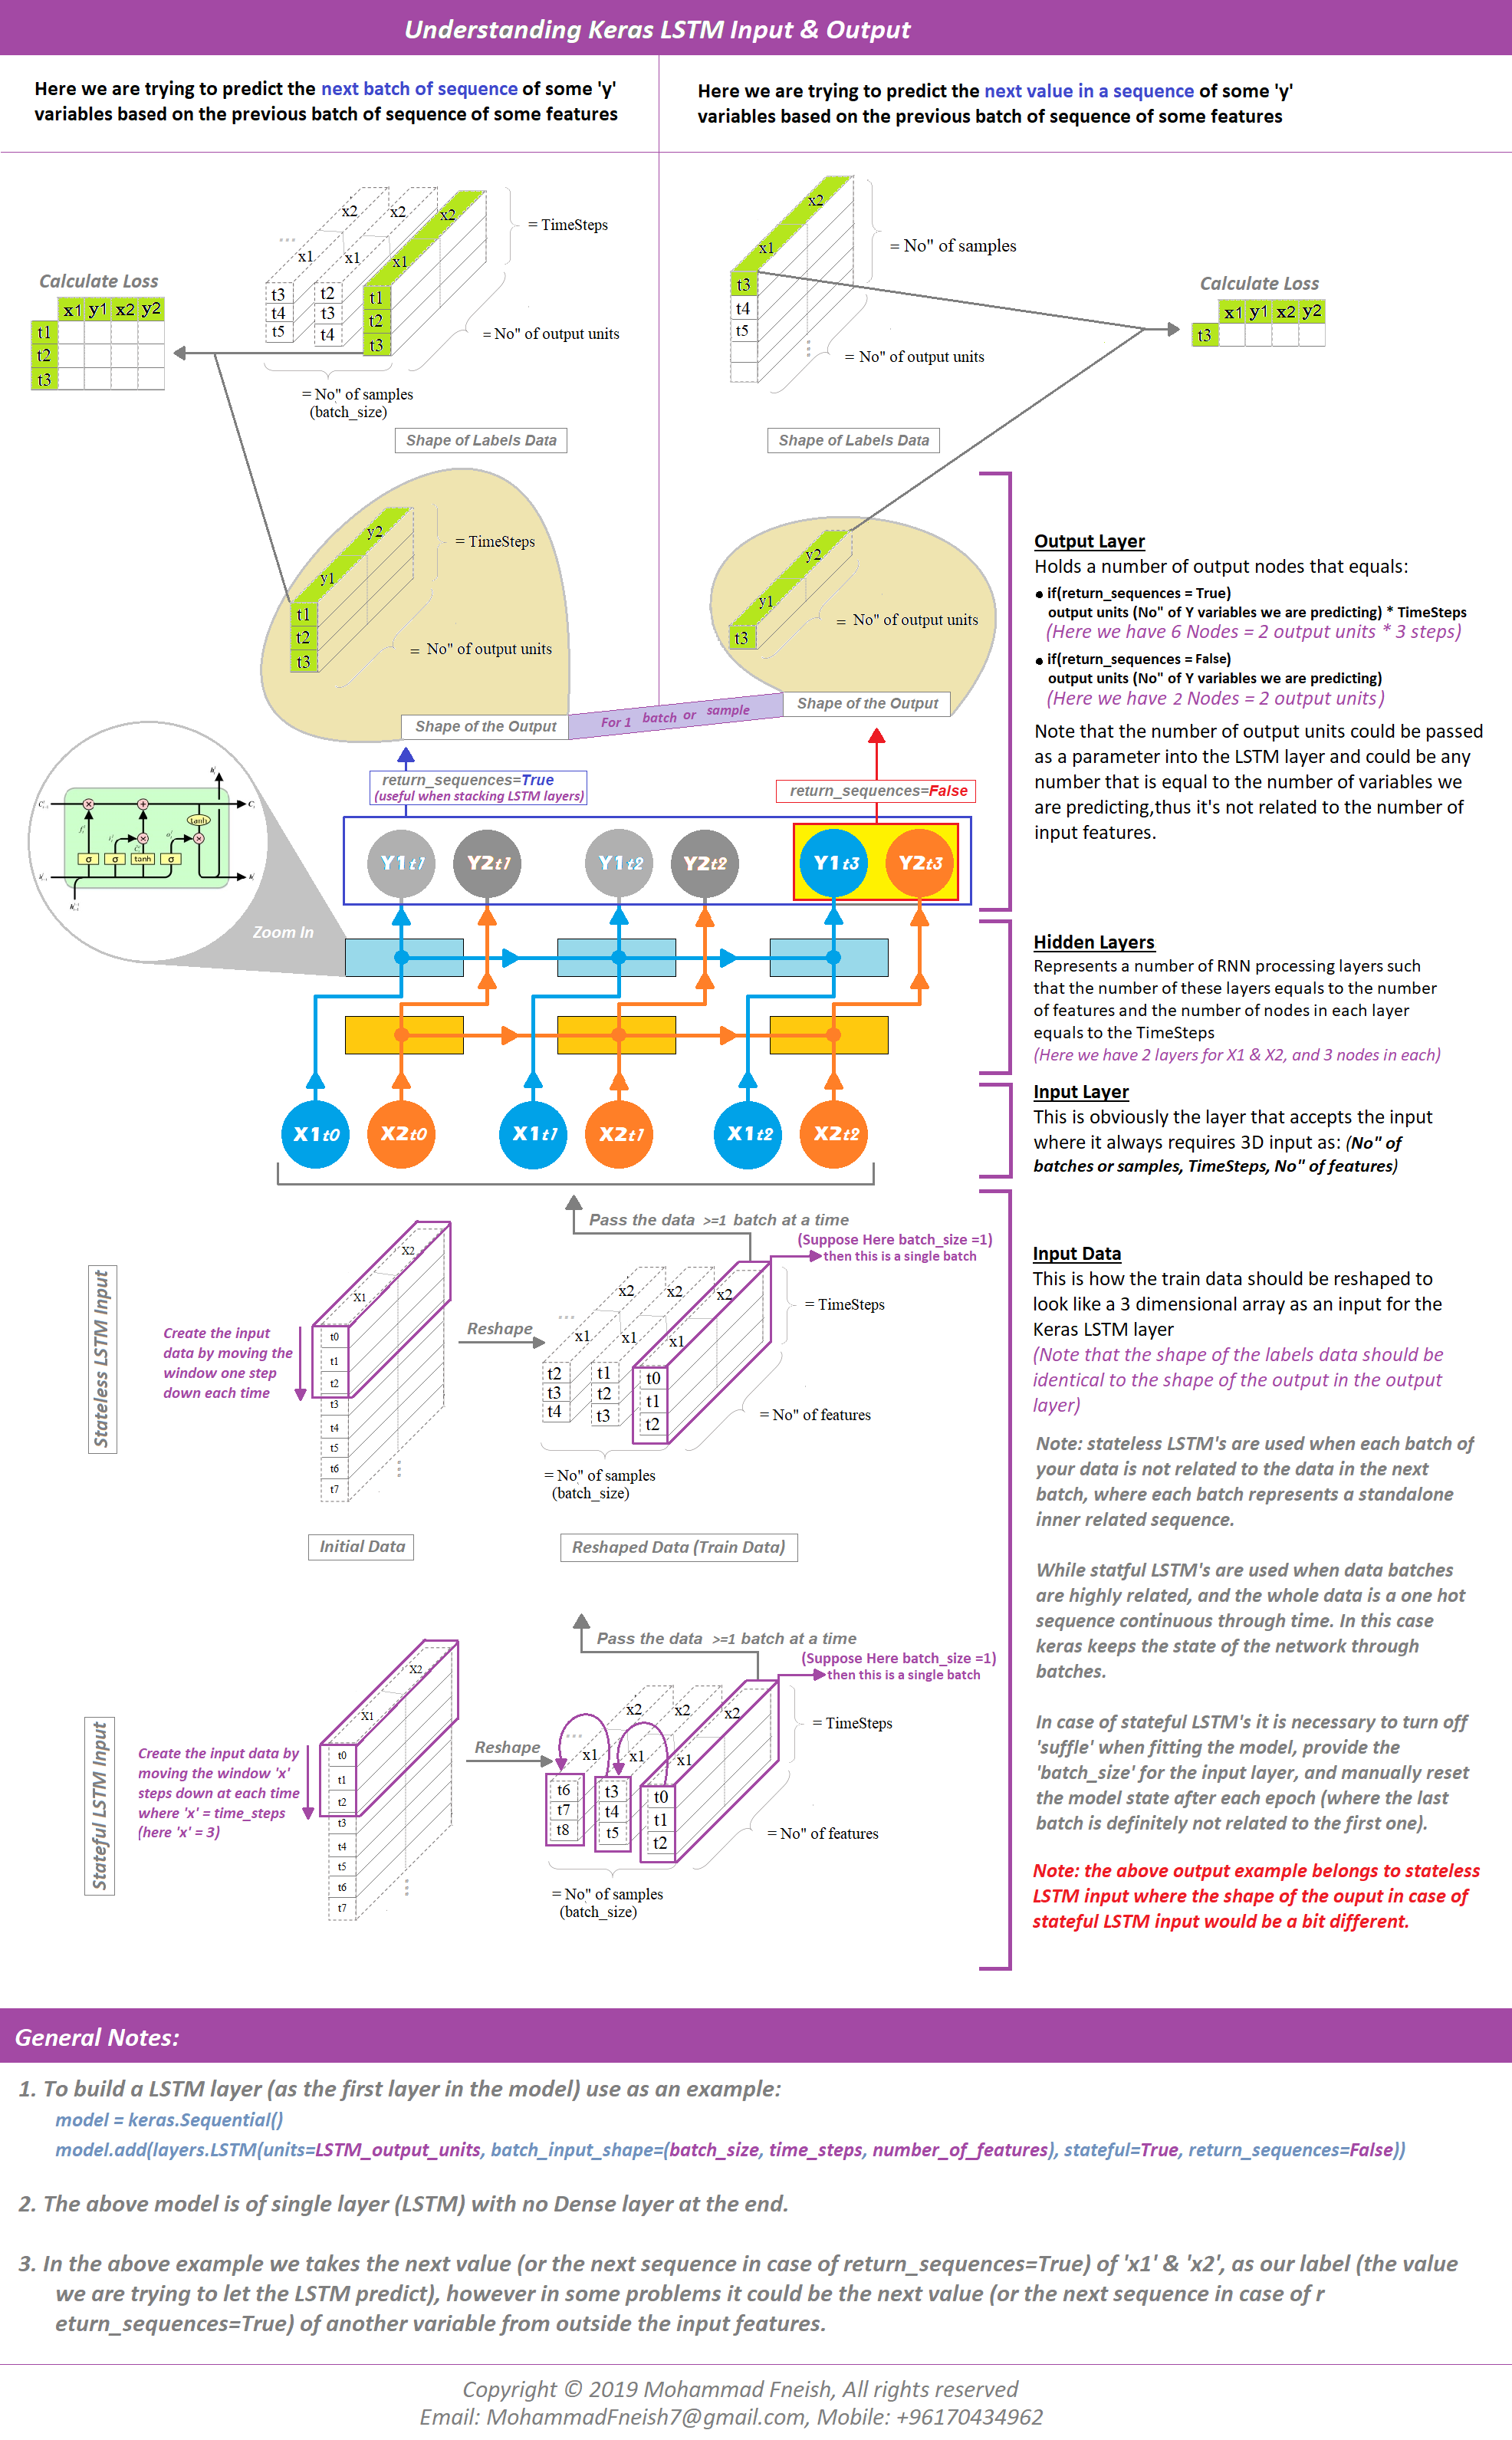

In [ ]:
def import_libs():
    # Importing the libraries
    global np; import numpy as np
    global plt; import matplotlib.pyplot as plt; plt.style.use('fivethirtyeight')
    global pd; import pandas as pd
    global MinMaxScaler; from sklearn.preprocessing import MinMaxScaler
    global Sequential; from keras.models import Sequential
    global Dense, LSTM, Dropout, GRU, Bidirectional; from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
    global SGD; from keras.optimizers import SGD
    global math; import math
    global mean_squared_error; from sklearn.metrics import mean_squared_error
import_libs()
# rcParams

In [ ]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


# First, we get the data
dataset = pd.read_csv('../input/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
print('Tail of the dataset is: \n\n {}:'.format(dataset.tail()))

In [ ]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values
# dataset[:'2016'].iloc[:,0:2].isnull().sum()
# len(dataset[:'2016'].iloc[:,1:2].values)

# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price');plt.show()

In [ ]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1)); training_set_scaled = sc.fit_transform(training_set)
# print(training_set_scaled[:20], end='\n\n'); print(training_set[:20])


def X_y_split(lookback):
    # Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
    # So for each element of training set, we have 60 previous training set elements 
    X_train=[training_set_scaled[i-lookback:i,0] for i in range(lookback, len(training_set))]
    y_train=[training_set_scaled[i,0] for i in range(lookback, len(training_set))]
    # X_train = []; y_train = []
    # for i in range(60,len(training_set)): # len(training_set) # = 2769
    #     X_train.append(training_set_scaled[i-60:i,0])
    #     y_train.append(training_set_scaled[i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    # X_train[:20][1]; X_train.shape; y_train.shape
    return X_train, y_train

X_train, y_train=X_y_split(60)


def X_y_reshape(single_y_size, x, y):
    if float(single_y_size).is_integer():
        x=[x[i] for i in range(0,len(y)-len(y)%single_y_size,single_y_size)]
        y=[y[i:i+single_y_size] for i in range(0,len(y)-len(y)%single_y_size,single_y_size)]
    else:
        print('Need an integer!')
    return np.array(x), np.array(y)

X_train, y_train=X_y_reshape(1,X_train, y_train)

# Reshaping X_train for efficient modelling, why do we need another index?? 
# .fit() in the next codeblock somehow expects 3 dimensions for the X_input 
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1)) # 2709 x 60 x 1, 1 means only one feature 'price'
# Always give a 3D array as an input to LSTM network. 
# 1st dimension represents the number of samples (or batch size)
# 2nd dimension represents the number of time-steps you are feeding a sequence. 
# 3rd dimension represents the number of units/features in one input sequence.
# X_train.shape  # X_train[:][:][0]
print(X_train.shape);print(y_train.shape)

* Num_params_1st_layer= 4xUNITSx(units+1+1)=4x50x(50+1+1)=10400; units is the number of outputs of this layer
* Num_params_2nd_layer= 4xUNITSx(units+output_from_1st_layer+1)=4x50x(50+1+1)=10400

In [ ]:
def build(X, y, batch_size, epoch):
    # The LSTM architecture
    regressor = Sequential()
    #=======================================================================================================================
    # return_sequences: Whether to return the last output. in the output sequence, or the full sequence. Default: False.
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1],1))) 
    #if using batch_input_shape=( , , ), the 1st number 'batch_size' must be a factor of 2709
    # we cannot really give any batch_size here if using batch_input_shape= (, ,), but if we use input_shape=(), we can later
    # specify the batch_size in fit(), which doesn't reshape the actual input data.
    regressor.add(Dropout(0.2))
    #=======================================================================================================================
    regressor.add(LSTM(units=50, return_sequences=True));regressor.add(Dropout(0.2))
    # 1st dimension of output is None because we do not know the batch size in advance. See the console log below
    #=======================================================================================================================
    regressor.add(LSTM(units=50, return_sequences=True));regressor.add(Dropout(0.2))
    #=======================================================================================================================
    regressor.add(LSTM(units=50));regressor.add(Dropout(0.2))
    # The output layer
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
    regressor.summary()
    history=regressor.fit(X,y,epochs=epoch, batch_size=batch_size)
    return regressor

regressor= build(X_train, y_train, batch_size=50, epoch=30)

# # Fitting to the training set
# history=regressor.fit(X_train,y_train,epochs=30,batch_size=32) # history.history.keys() shows dict_keys(['loss'])
# # vars(history) shows what 'history' class has to offer


In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so the first 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values # 251+60 =311
# print(len(dataset_total[len(dataset_total)-len(test_set) - 60:].values)) # =311
# len(test_set) # = 251
# len(dataset_total) # = 3020

#shape into one column as indicated by '1', but the row number has to be compatible with the original list
inputs = inputs.reshape(-1,1); #(-1, ) simply means that it is an unknown dimension and we want numpy to figure it out.
# print(inputs) #gives ONE column of numbers
inputs  = sc.transform(inputs)
# print(inputs.shape) # (311, 1)
# print(len(test_set)) # =251

In [ ]:
def test_prep(lookback,data):
    # Preparing X_test and predicting the prices
    X_test = [data[i-lookback:i,0] for i in range(lookback,lookback+len(test_set))]
    X_test = np.array(X_test); X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
#     print(X_test.shape) # (251, 60, 1)
    return X_test

X_test=test_prep(60,inputs) # (251, 60, 1)

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

Truth be told. That's one awesome score. 

LSTM is not the only kind of unit that has taken the world of Deep Learning by a storm. We have **Gated Recurrent Units(GRU)**. It's not known, which is better: GRU or LSTM becuase they have comparable performances. GRUs are easier to train than LSTMs.

## Gated Recurrent Units
In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the outpu, .neither they have the output gate.

Source: [Quora](https://www.quora.com/Whats-the-difference-between-LSTM-and-GRU-Why-are-GRU-efficient-to-train)

<img src="https://cdnpythonmachinelearning.azureedge.net/wp-content/uploads/2017/11/GRU.png?x31195">

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

## Sequence Generation
Here, I will generate a sequence using just initial 60 values instead of using last 60 values for every new prediction. **Due to doubts in various comments about predictions making use of test set values, I have decided to include sequence generation.** The above models make use of test set so it is using last 60 true values for predicting the new value(I will call it a benchmark). This is why the error is so low. Strong models can bring similar results like above models for sequences too but they require more than just data which has previous values. In case of stocks, we need to know the sentiments of the market, the movement of other stocks and a lot more. So, don't expect a remotely accurate plot. The error will be great and the best I can do is generate the trend similar to the test set.

I will use GRU model for predictions. You can try this using LSTMs also. I have modified GRU model above to get the best sequence possible. I have run the model four times and two times I got error of around 8 to 9. The worst case had an error of around 11. Let's see what this iterations.

The GRU model in the previous versions is fine too. Just a little tweaking was required to get good sequences. **The main goal of this kernel is to show how to build RNN models. How you predict data and what kind of data you predict is up to you. I can't give you some 100 lines of code where you put the destination of training and test set and get world-class results. That's something you have to do yourself.**

In [ ]:
# Preparing sequence data
initial_sequence = X_train[2708,:]
sequence = []
for i in range(251):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

In [ ]:
# Visualizing the sequence
plot_predictions(test_set,sequence)

In [ ]:
# Evaluating the sequence
return_rmse(test_set,sequence)

So, GRU works better than LSTM in this case. Bidirectional LSTM is also a good way so make the model stronger. But this may vary for different data sets. **Applying both LSTM and GRU together gave even better results.** 

#### I was going to cover text generation using LSTM but already an excellent kernel by [Shivam Bansal](https://www.kaggle.com/shivamb) on the mentioned topic exists. Link for that kernel here: https://www.kaggle.com/shivamb/beginners-guide-to-text-generation-using-lstms

#### This is certainly not the end. Stay tuned for more stuff!